In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This dataser contains 5 sub-directories, one per class: \

flower_photo /\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;daisy /\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;dandelion /\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;roses /\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;sunflowers /\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;tulips /

In [39]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [40]:
image_count = len(list(data_dir.glob("*/*.jpg")))

print(f"The dataset has {image_count} images")

The dataset has 3670 images


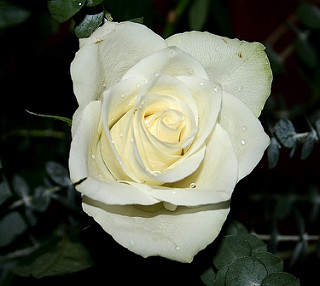

In [41]:
# Visualize an instance
import random 

roses = list(data_dir.glob("roses/*"))

index = random.randint(0, len(roses))
PIL.Image.open(str(roses[index]))

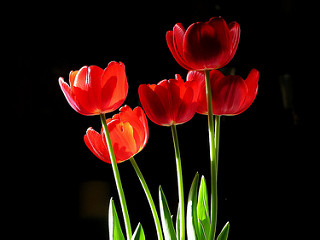

In [42]:
tulips = list(data_dir.glob("tulips/*"))

PIL.Image.open(str(tulips[index]))

## Train and validation data split

In [43]:
# Create training and validation dataset
img_height = 180 
img_width = 180
batch_size= 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, # 20% for validation 
    subset="training", 
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [44]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    subset="validation",
    seed=123, 
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [45]:
print("Dataset's class names: ")

classes = train_data.class_names
print(classes)

Dataset's class names: 
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


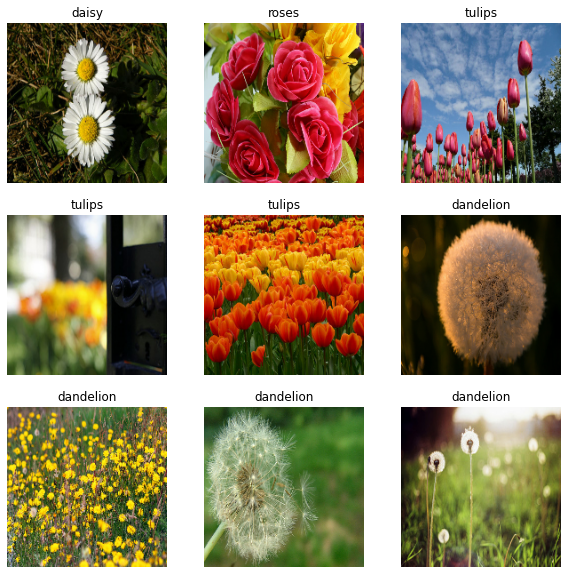

In [46]:
# Visualize some data
plt.figure(figsize=(10, 10))

for images, labels in train_data.take(2): 
    # Show 9 pictures of a batch
    for i in range(9): 
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[labels[i]])
        plt.axis("off")

In [54]:
for img_batch, labels_batch in train_data: 
    print(img_batch.shape)
    print(labels_batch.shape)
    print(f"This is a batch of {img_batch.shape[0]} images of shape {img_batch.shape[1]} x {img_batch.shape[2]} x {img_batch.shape[3]}")
    break

(32, 180, 180, 3)
(32,)
This is a batch of 32 images of shape 180 x 180 x 3


## Standarize the data

In [59]:
# Create a layer to normalize data
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_data = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_data))
first_image = image_batch[0]
print(f"The minimum value is: {np.min(first_image)}")
print(f"The maximum value is: {np.max(first_image)}")

The minimum value is: 0.0
The maximum value is: 0.8702609539031982


## Create the Neural Network Model

In [60]:
num_classes = len(classes)

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),# 16 channels, kernel size 3
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"), 
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes),
])

In [61]:
# Compile the model 
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [62]:
# Model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Model training

In [64]:
epochs = 10 

history = model.fit(
    train_data, 
    validation_data = val_data, 
    epochs = epochs
)

Epoch 1/10
92/92 [==============================] - 51s 548ms/step - loss: 1.1744 - accuracy: 0.4908 - val_loss: 1.0395 - val_accuracy: 0.6035
Epoch 2/10
92/92 [==============================] - 50s 537ms/step - loss: 0.9827 - accuracy: 0.6090 - val_loss: 1.0135 - val_accuracy: 0.6213
Epoch 3/10
92/92 [==============================] - 50s 537ms/step - loss: 0.7563 - accuracy: 0.7166 - val_loss: 0.9473 - val_accuracy: 0.6158
Epoch 4/10
92/92 [==============================] - 49s 533ms/step - loss: 0.5506 - accuracy: 0.7973 - val_loss: 0.9712 - val_accuracy: 0.6417
Epoch 5/10
92/92 [==============================] - 50s 539ms/step - loss: 0.3575 - accuracy: 0.8770 - val_loss: 1.1685 - val_accuracy: 0.6213
Epoch 6/10
92/92 [==============================] - 50s 538ms/step - loss: 0.2407 - accuracy: 0.9210 - val_loss: 1.2789 - val_accuracy: 0.6417
Epoch 7/10
92/92 [==============================] - 51s 550ms/step - loss: 0.1614 - accuracy: 0.9503 - val_loss: 1.7550 - val_accuracy: 0.6144

## Training results visualization

Text(0.5, 1.0, 'Training and validation loss')

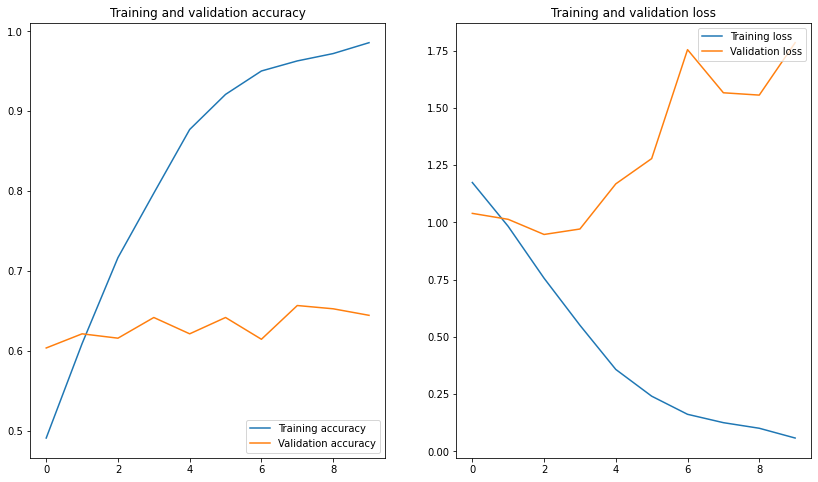

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc='upper right')
plt.title('Training and validation loss')

## Model regularization

In [66]:
# Data augmentation 
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0,1),
])

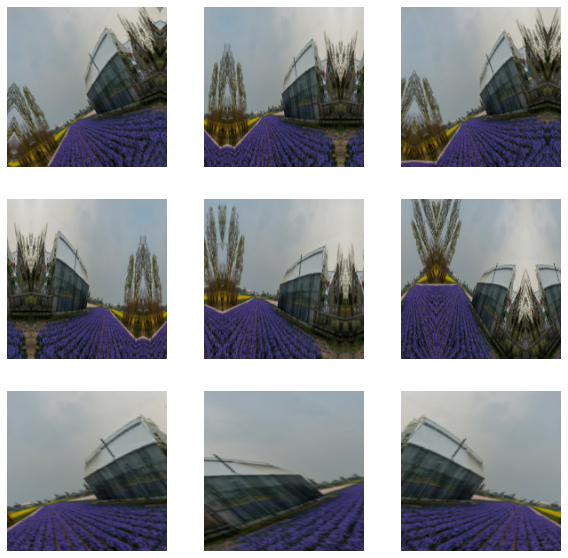

In [70]:
# Visaulize some augmented instances
plt.figure(figsize=(10, 10))

for images, labels in train_data.take(1): 
    for i in range(9): 
        augmented = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented[0].numpy().astype('uint8'))
        plt.axis('off')

In [72]:
# Create a model with Dropout regularization 
model = Sequential([
    data_augmentation, 
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),# 16 channels, kernel size 3
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation="relu"), 
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes),
])

In [73]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [74]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [75]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 57s 606ms/step - loss: 1.8173 - accuracy: 0.2797 - val_loss: 1.2517 - val_accuracy: 0.5177
Epoch 2/10
92/92 [==============================] - 57s 611ms/step - loss: 1.2450 - accuracy: 0.4937 - val_loss: 1.1780 - val_accuracy: 0.5313
Epoch 3/10
92/92 [==============================] - 56s 607ms/step - loss: 1.1128 - accuracy: 0.5585 - val_loss: 1.0811 - val_accuracy: 0.5531
Epoch 4/10
92/92 [==============================] - 56s 605ms/step - loss: 1.0331 - accuracy: 0.5904 - val_loss: 1.0329 - val_accuracy: 0.5777
Epoch 5/10
92/92 [==============================] - 57s 614ms/step - loss: 0.9707 - accuracy: 0.6297 - val_loss: 0.8968 - val_accuracy: 0.6485
Epoch 6/10
92/92 [==============================] - 56s 607ms/step - loss: 0.9054 - accuracy: 0.6392 - val_loss: 0.8801 - val_accuracy: 0.6499
Epoch 7/10
92/92 [==============================] - 56s 605ms/step - loss: 0.8717 - accuracy: 0.6607 - val_loss: 0.8465 - val_accuracy: 0.6635

## Visualize training results (with regularization)

Text(0.5, 1.0, 'Training and validation loss')

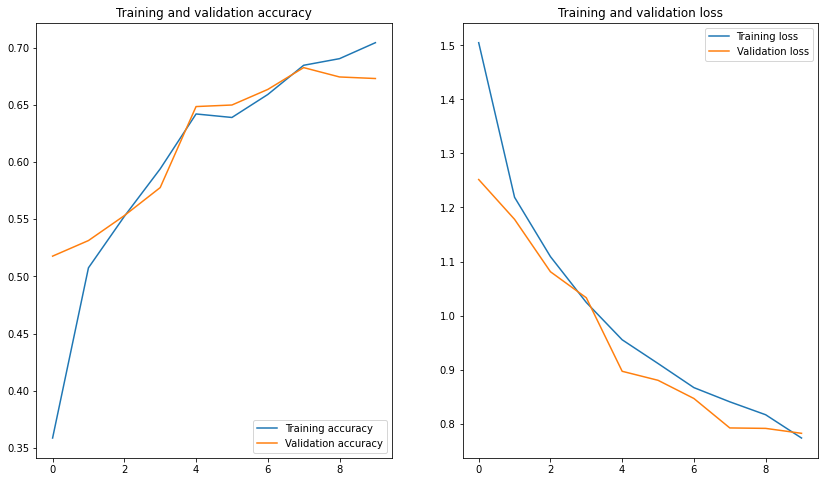

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc='upper right')
plt.title('Training and validation loss')

## Make predictions

In [79]:
# Get data
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file("Red_sunflower", origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)

In [82]:
img_array = keras.preprocessing.image.img_to_array(img)
print(f"Image shape: {img_array.shape}")

# Create a batch 
img_array = tf.expand_dims(img_array, 0)
print(img_array.shape)

Image shape: (180, 180, 3)
(1, 180, 180, 3)


In [87]:
# Predict

# Array of probabilities of each class
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f}% of confidence".format(classes[np.argmax(score)], 100*np.max(score)))

This image most likely belongs to sunflowers with a 72.38% of confidence
